In [40]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import func_plot as fp
import seaborn as sns
import nibabel as nib
from scipy.stats import norm
atlas = nib.load('./BD-SCZ/Schaefer2018_400Parcels_7Networks_order.dlabel.nii').get_fdata()[0]
atlas.shape

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(64984,)

# Gradient 1 parcelwise PLS

In [41]:
# Load aligned Gradient 1
grad_df = pd.read_csv('./g1_aligned.csv')

# Select only patients (diagnosis 2 or 3)
patient_df = grad_df[grad_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 1 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X = patient_df[parcel_cols].values  # shape: (n_patients, 400)

# Behavioral/clinical measures
clinical_vars = ['SAPS disorganization', 'Amotivation', 'DimEx',
                 'SAPS Positive Symptoms', 'hamilton_21']
Y = patient_df[clinical_vars].values  # shape: (n_patients, 5)

# Remove patients with any NaNs in behavioral measures
valid = ~np.isnan(Y).any(axis=1)
X_valid = X[valid]
Y_valid = Y[valid]

print(f"X_valid shape: {X_valid.shape}, Y_valid shape: {Y_valid.shape}")

# Standardize across patients
X_std = StandardScaler().fit_transform(X_valid)
Y_std = StandardScaler().fit_transform(Y_valid)

# Fit PLS
pls = PLSRegression(n_components=1)
pls.fit(X_std, Y_std)

# Saliences (loadings)
X_saliences = pls.x_loadings_[:,0]  # parcel-wise loadings (400,)
Y_saliences = pls.y_loadings_[:,0]  # behavioral loadings (5,)

# Individual composite scores
X_scores = pls.x_scores_[:,0]  # patient-specific Gradient 1 LC1
Y_scores = pls.y_scores_[:,0]  # patient-specific behavioral LC1
from scipy.stats import pearsonr

# Correlation of each behavioral measure with LC1. These correlations are used to interpret which behaviors are most strongly represented in LC1.
behav_corrs = [pearsonr(Y_std[:,i], Y_scores)[0] for i in range(Y_std.shape[1])]
print("Behavioral correlations with LC1:")
for b, c in zip(clinical_vars, behav_corrs):
    print(f"{b}: {c:.3f}")

X_valid shape: (73, 400), Y_valid shape: (73, 5)
Behavioral correlations with LC1:
SAPS disorganization: -0.681
Amotivation: -0.807
DimEx: -0.594
SAPS Positive Symptoms: -0.808
hamilton_21: -0.456


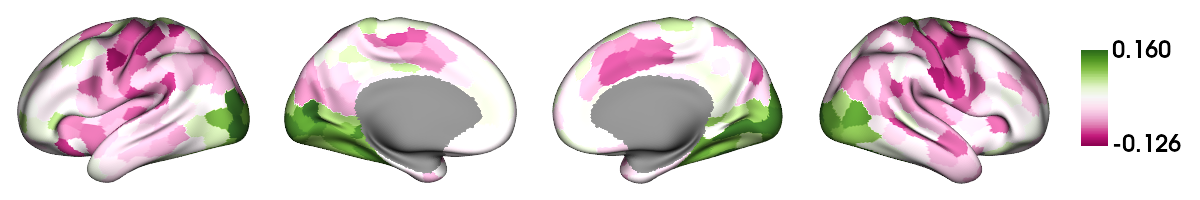

In [42]:
brain_map = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X_saliences)):
    brain_map[atlas == j+1] = X_saliences[j]
brain_map[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map],
    size=(1200, 200),
    cmap='PiYG',
    display=True,
    filename='./figures/Gradient1_LC1_map.png'
)


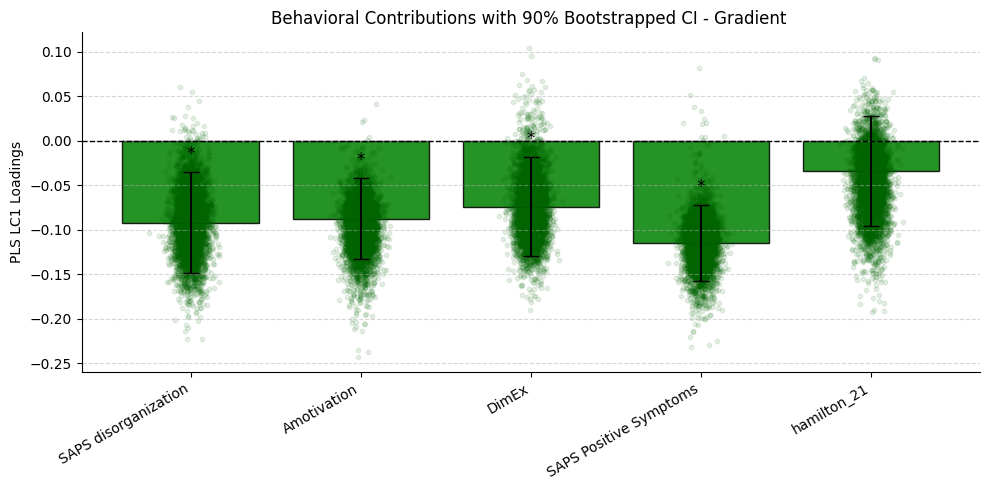

In [43]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(4)
n_behav = Y_std.shape[1]
boot_y_saliences = np.zeros((n_boot, n_behav))

for b in range(n_boot):
    idx = np.random.choice(len(X_std), size=len(X_std), replace=True)
    Xb = X_std[idx]
    Yb = Y_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y_saliences) < 0:
        yb *= -1
 
    boot_y_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y_saliences
y_sd = boot_y_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values =  2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='green', alpha=0.85, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav):
    y = boot_y_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='darkgreen', alpha=0.1, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav))
ax.set_xticklabels(clinical_vars, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient ')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


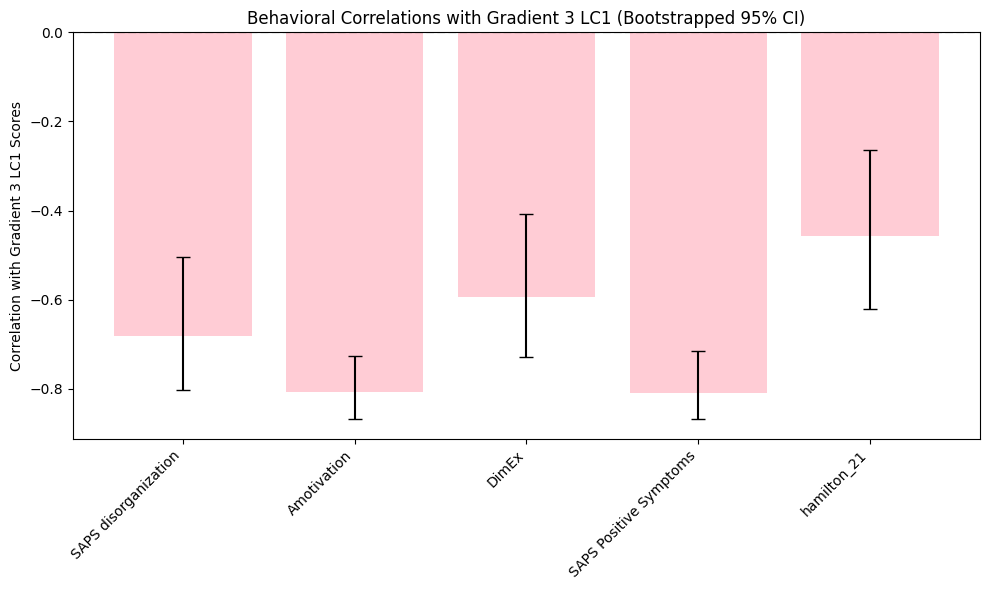

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs = np.array([pearsonr(Y_std[:, i], Y_scores)[0] for i in range(Y_std.shape[1])])

# Bootstrap correlations
boot_corrs = np.zeros((n_boot, len(clinical_vars)))
for b in range(n_boot):
    idx = np.random.choice(len(Y_std), size=len(Y_std), replace=True)
    Yb = Y_std[idx, :]
    scores_b = Y_scores[idx]
    boot_corrs[b, :] = [pearsonr(Yb[:, i], scores_b)[0] for i in range(Y_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs - lower_ci
yerr_upper = upper_ci - behav_corrs
yerr = np.vstack((yerr_lower, yerr_upper))

# Coloring based on worse outcomes
worse_if_higher = ['SAPS disorganization', 'Amotivation', 'DimEx',
                   'SAPS Positive Symptoms', 'hamilton_31']

# Plot
plt.figure(figsize=(10,6))
plt.bar(clinical_vars, behav_corrs, yerr=yerr, capsize=5, color='pink', alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Gradient 3 LC1 Scores')
plt.title('Behavioral Correlations with Gradient 3 LC1 (Bootstrapped 95% CI)')
plt.tight_layout()
plt.show()


# Gradient 2 parcelwise PLS

In [45]:
# Load aligned Gradient 2
grad2_df = pd.read_csv('./g2_aligned.csv')

# Select only patients (diagnosis 2 or 3)
patient2_df = grad2_df[grad2_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 2 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X2 = patient2_df[parcel_cols].values

# Behavioral measures
clinical_vars2 = ['SAPS disorganization', 'Amotivation', 'DimEx',
                  'SAPS Positive Symptoms', 'hamilton_21']
Y2 = patient2_df[clinical_vars2].values

# Remove patients with NaNs
valid2 = ~np.isnan(Y2).any(axis=1)
X2_valid = X2[valid2]
Y2_valid = Y2[valid2]

print(f"X2_valid shape: {X2_valid.shape}, Y2_valid shape: {Y2_valid.shape}")

# Standardize
X2_std = StandardScaler().fit_transform(X2_valid)
Y2_std = StandardScaler().fit_transform(Y2_valid)

# Fit PLS
pls2 = PLSRegression(n_components=1)
pls2.fit(X2_std, Y2_std)

# Saliences (loadings)
X2_saliences = pls2.x_loadings_[:,0]
Y2_saliences = pls2.y_loadings_[:,0]

# Individual composite scores
X2_scores = pls2.x_scores_[:,0]
Y2_scores = pls2.y_scores_[:,0]

# Behavioral correlations with LC1
behav_corrs2 = [pearsonr(Y2_std[:,i], Y2_scores)[0] for i in range(Y2_std.shape[1])]
print("Behavioral correlations with Gradient 2 LC1:")
for b, c in zip(clinical_vars2, behav_corrs2):
    print(f"{b}: {c:.3f}")


X2_valid shape: (73, 400), Y2_valid shape: (73, 5)
Behavioral correlations with Gradient 2 LC1:
SAPS disorganization: -0.622
Amotivation: -0.807
DimEx: -0.614
SAPS Positive Symptoms: -0.792
hamilton_21: -0.553


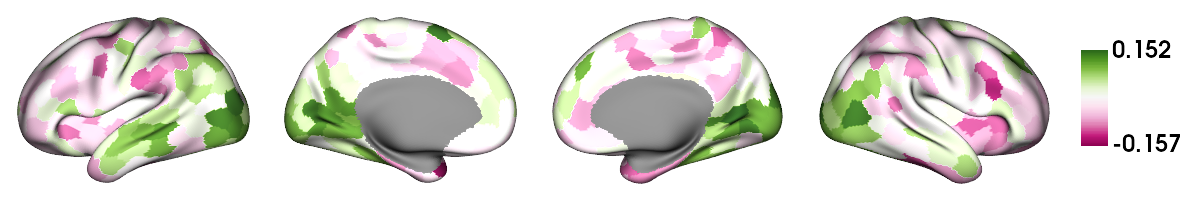

In [46]:
# Create brain map
brain_map2 = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X2_saliences)):
    brain_map2[atlas == j+1] = X2_saliences[j]
brain_map2[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map2],
    size=(1200, 200),
    cmap='PiYG',
    display=True,
    filename='./figures/Gradient2_LC1_map.png'
)


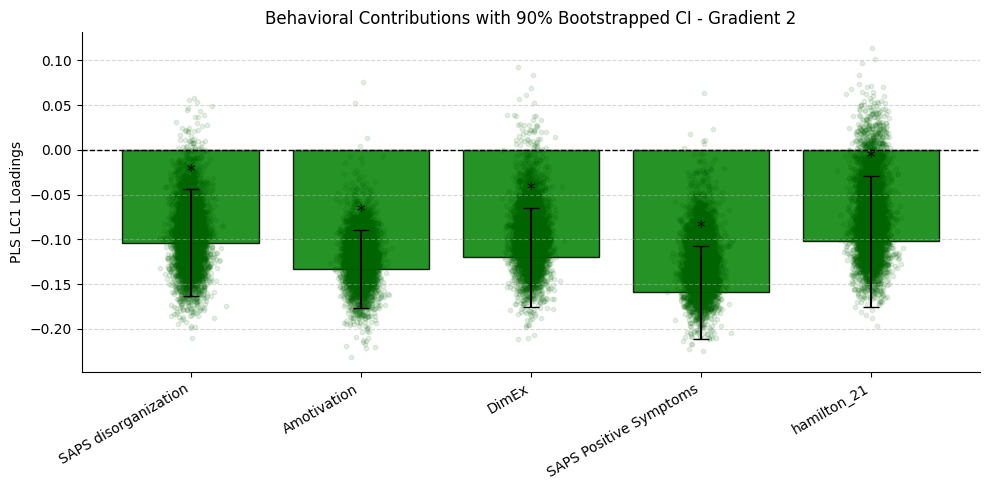

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(42)
n_behav2 = Y2_std.shape[1]
boot_y2_saliences = np.zeros((n_boot, n_behav2))

for b in range(n_boot):
    idx = np.random.choice(len(X2_std), size=len(X2_std), replace=True)
    Xb = X2_std[idx]
    Yb = Y2_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y2_saliences) < 0:
        yb *= -1

    boot_y2_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y2_saliences
y_sd = boot_y2_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav2), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='green', alpha=0.85, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav2):
    y = boot_y2_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='darkgreen', alpha=0.1, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav2):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav2))
ax.set_xticklabels(clinical_vars2, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


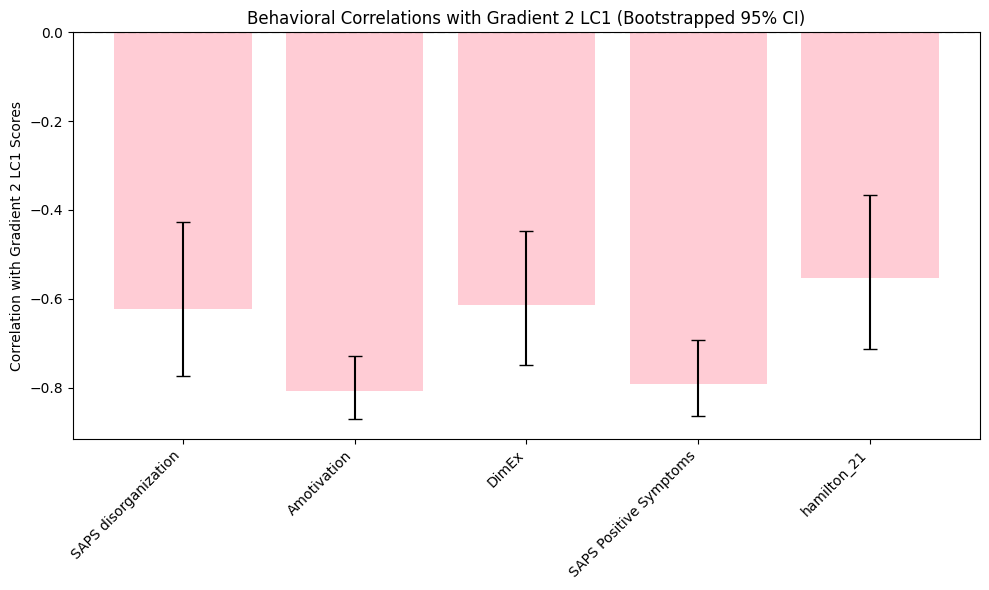

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs2 = np.array([pearsonr(Y2_std[:, i], Y2_scores)[0] for i in range(Y2_std.shape[1])])

# Bootstrap correlations
boot_corrs2 = np.zeros((n_boot, len(clinical_vars2)))
for b in range(n_boot):
    idx = np.random.choice(len(Y2_std), size=len(Y2_std), replace=True)
    Yb = Y2_std[idx, :]
    scores_b = Y2_scores[idx]
    boot_corrs2[b, :] = [pearsonr(Yb[:, i], scores_b)[0] for i in range(Y2_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs2, 2.5, axis=0)
upper_ci = np.percentile(boot_corrs2, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs2 - lower_ci
yerr_upper = upper_ci - behav_corrs2
yerr = np.vstack((yerr_lower, yerr_upper))

# Coloring based on worse outcomes
worse_if_higher = ['SAPS disorganization', 'Amotivation', 'DimEx',
                   'SAPS Positive Symptoms', 'hamilton_21']

# Plot
plt.figure(figsize=(10,6))
plt.bar(clinical_vars2, behav_corrs2, yerr=yerr, capsize=5, color='pink', alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Gradient 2 LC1 Scores')
plt.title('Behavioral Correlations with Gradient 2 LC1 (Bootstrapped 95% CI)')
plt.tight_layout()
plt.show()


# Gradient 3 parcelwise PLS

In [49]:
# Load aligned Gradient 3
grad3_df = pd.read_csv('./g3_aligned.csv')

# Select only patients (diagnosis 2 or 3)
patient3_df = grad3_df[grad3_df['diagnosis'].isin([2, 3])].copy()

# Extract Gradient 3 parcel values
parcel_cols = [f'node_{i+1}' for i in range(400)]
X3 = patient3_df[parcel_cols].values

# Behavioral measures
clinical_vars3 = ['SAPS disorganization', 'Amotivation', 'DimEx',
                  'SAPS Positive Symptoms', 'hamilton_21']
Y3 = patient3_df[clinical_vars3].values

# Remove patients with NaNs
valid3 = ~np.isnan(Y3).any(axis=1)
X3_valid = X3[valid3]
Y3_valid = Y3[valid3]

print(f"X3_valid shape: {X3_valid.shape}, Y3_valid shape: {Y3_valid.shape}")

# Standardize
X3_std = StandardScaler().fit_transform(X3_valid)
Y3_std = StandardScaler().fit_transform(Y3_valid)

# Fit PLS
pls3 = PLSRegression(n_components=1)
pls3.fit(X3_std, Y3_std)

# Saliences (loadings)
X3_saliences = pls3.x_loadings_[:,0]
Y3_saliences = pls3.y_loadings_[:,0]

# Individual composite scores
X3_scores = pls3.x_scores_[:,0]
Y3_scores = pls3.y_scores_[:,0]

# Behavioral correlations with LC1
behav_corrs3 = [pearsonr(Y3_std[:,i], Y3_scores)[0] for i in range(Y3_std.shape[1])]
print("Behavioral correlations with Gradient 3 LC1:")
for b, c in zip(clinical_vars3, behav_corrs3):
    print(f"{b}: {c:.3f}")

X3_valid shape: (73, 400), Y3_valid shape: (73, 5)
Behavioral correlations with Gradient 3 LC1:
SAPS disorganization: 0.682
Amotivation: 0.822
DimEx: 0.531
SAPS Positive Symptoms: 0.747
hamilton_21: 0.604


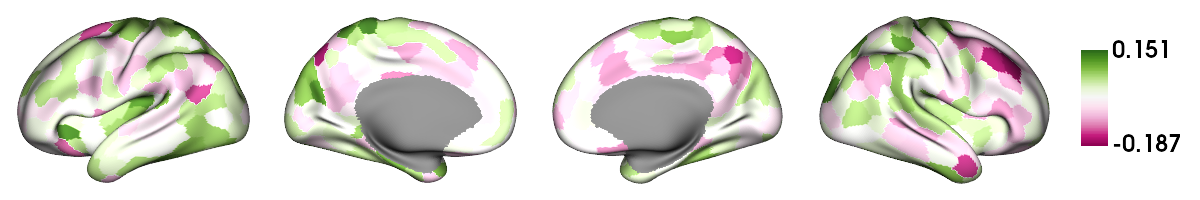

In [50]:
# Create brain map
brain_map3 = np.full_like(atlas, np.nan, dtype=float)
for j in range(len(X3_saliences)):
    brain_map3[atlas == j+1] = X3_saliences[j]
brain_map3[atlas == 0] = np.nan

fp.plot_surface(
    data=[brain_map3],
    size=(1200, 200),
    cmap='PiYG',
    display=True,
    filename='./figures/Gradient3_LC1_map.png'
)


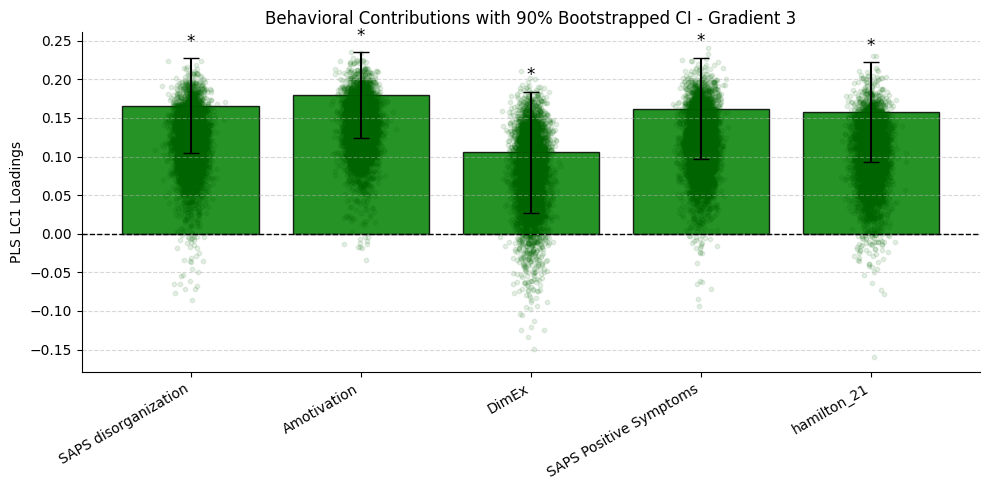

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import norm

# Bootstrapping behavioral loadings
n_boot = 5000
np.random.seed(43)
n_behav3 = Y3_std.shape[1]
boot_y3_saliences = np.zeros((n_boot, n_behav3))

for b in range(n_boot):
    idx = np.random.choice(len(X3_std), size=len(X3_std), replace=True)
    Xb = X3_std[idx]
    Yb = Y3_std[idx]

    plsb = PLSRegression(n_components=1)
    plsb.fit(Xb, Yb)
    yb = plsb.y_loadings_[:, 0]

    if np.dot(yb, Y3_saliences) < 0:
        yb *= -1

    boot_y3_saliences[b, :] = yb

# Mean, SD, CI, p-values
y_mean = Y3_saliences
y_sd = boot_y3_saliences.std(axis=0)
lower_ci = y_mean - 1.645 * y_sd
upper_ci = y_mean + 1.645 * y_sd
p_values = 2 * (1 - norm.cdf(np.abs(y_mean / y_sd)))

# Simple linear colormap from min → max
cmap = plt.get_cmap('PiYG')
colors = [cmap((val - y_mean.min()) / (y_mean.max() - y_mean.min())) for val in y_mean]

# Plot
fig, ax = plt.subplots(figsize=(10,5))
bars = ax.bar(range(n_behav3), y_mean,
              yerr=[y_mean - lower_ci, upper_ci - y_mean],
              capsize=6, color='green', alpha=0.85, edgecolor='black')

# Overlay faint bootstrap points
for i in range(n_behav3):
    y = boot_y3_saliences[:, i]
    x = np.random.normal(i, 0.05, size=len(y))
    ax.scatter(x, y, color='darkgreen', alpha=0.1, s=10)

# Horizontal line at zero
ax.axhline(0, color='black', linestyle='--', linewidth=1)

# Significance stars (CI not crossing zero)
for i in range(n_behav3):
    if lower_ci[i] > 0 or upper_ci[i] < 0:
        ax.text(i, upper_ci[i] + 0.01, "*", ha='center', va='bottom', fontsize=12)

# Labels and aesthetics
ax.set_xticks(range(n_behav3))
ax.set_xticklabels(clinical_vars3, rotation=30, ha='right')
ax.set_ylabel('PLS LC1 Loadings')
ax.set_title('Behavioral Contributions with 90% Bootstrapped CI - Gradient 3')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


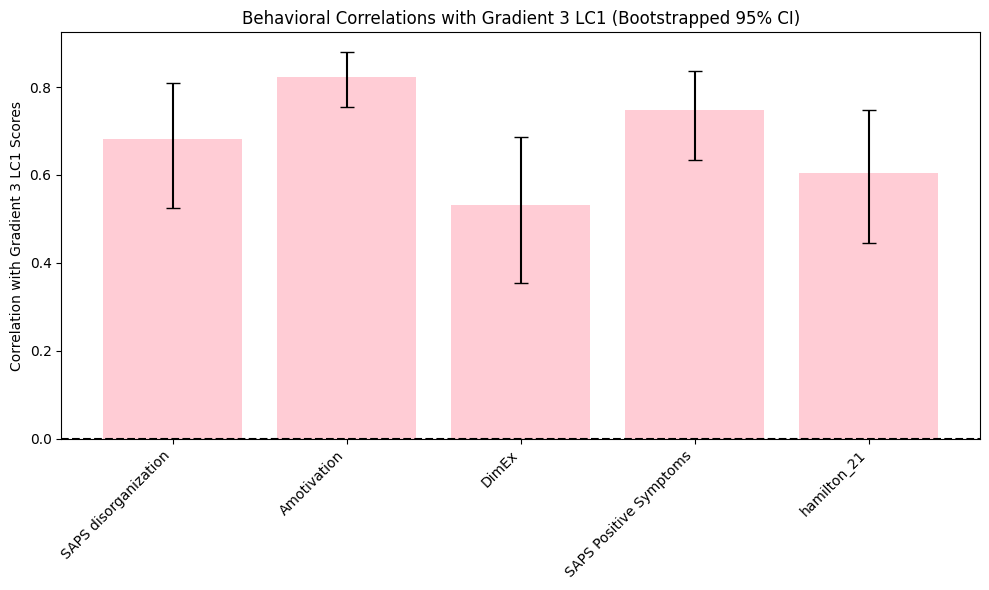

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Original correlations
behav_corrs3 = np.array([pearsonr(Y3_std[:, i], Y3_scores)[0] for i in range(Y3_std.shape[1])])

# Bootstrap correlations
boot_corrs3 = np.zeros((n_boot, len(clinical_vars3)))
for b in range(n_boot):
    idx = np.random.choice(len(Y3_std), size=len(Y3_std), replace=True)
    Yb = Y3_std[idx, :]
    scores_b = Y3_scores[idx]
    boot_corrs3[b, :] = [pearsonr(Yb[:, i], scores_b)[0] for i in range(Y3_std.shape[1])]

# Compute 95% confidence intervals
lower_ci = np.percentile(boot_corrs3, 3.5, axis=0)
upper_ci = np.percentile(boot_corrs3, 97.5, axis=0)

# Error bars = distance from mean to CI
yerr_lower = behav_corrs3 - lower_ci
yerr_upper = upper_ci - behav_corrs3
yerr = np.vstack((yerr_lower, yerr_upper))

# Coloring based on worse outcomes
worse_if_higher = ['SAPS disorganization', 'Amotivation', 'DimEx',
                   'SAPS Positive Symptoms', 'hamilton_31']

# Plot
plt.figure(figsize=(10,6))
plt.bar(clinical_vars3, behav_corrs3, yerr=yerr, capsize=5, color='pink', alpha=0.8)
plt.axhline(0, color='black', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Correlation with Gradient 3 LC1 Scores')
plt.title('Behavioral Correlations with Gradient 3 LC1 (Bootstrapped 95% CI)')
plt.tight_layout()
plt.show()
